# Time Series Demo

Written by Robert Morgan

This notebook will demonstrate the use of `deeplenstronomy` to create a time series of images.

In [1]:
import deeplenstronomy.deeplenstronomy as dl

For this example, we'll use the `demo_timeseries.yaml` config file, which already has timeseries functionality built in. It is the same demo file we have been using, but we have updated the entries for `SPECIES.POINTSOURCE_2` and `CONFIGURATION_3` to include the temporal evolution of the supernova in that system.

In [2]:
config_file = 'data/demo_timeseries.yaml'

In [3]:
! cat data/demo_timeseries.yaml

DATASET:
    NAME: MyDeeplenstronomyDataset
    PARAMETERS:
        SIZE: 100
        OUTDIR: MySimulationResultsTimeSeries

COSMOLOGY:
    PARAMETERS:
        H0: 70
        Om0: 0.3

IMAGE:
    PARAMETERS:
        exposure_time: 
            DISTRIBUTION:
                NAME: uniform
                PARAMETERS:
                    minimum: 60
                    maximum: 120
        numPix: 100
        pixel_scale: 0.263
        psf_type: 'GAUSSIAN'
        read_noise: 7
        ccd_gain: 6.083

SURVEY:
    PARAMETERS:
        BANDS: g,r,i,z,Y
        seeing: 0.9
        magnitude_zero_point: 30.0
        sky_brightness: 23.5
        num_exposures: 1

SPECIES:
    GALAXY_1:
        NAME: LENS
        LIGHT_PROFILE_1:
            NAME: SERSIC_ELLIPSE
            PARAMETERS:
                magnitude: 19.5
                center_x: 0.0
                center_y: 0.0
                R_sersic: 10
                n_sersic: 4
                e1: 0.2
                e2: -0.1
        LIGHT_P

_Note_: `SURVEY.num_exposures` must be set to 1 (to better reflect real time-series data) and cannot be drawn from a distribution if you are using any time-series features.

## Configuration File Keywords - MODEL

Check out the information in the `SPECIES` section for `POINTSOURCE_2`. You will notice the `MODEL` keyword is new and has not been used in other examples. Next, take a look at `CONFIGURATION_3`; you should see an entry for `TIMESERIES`. These two additions to the config file are all you need to utilize the time series features of `deeplenstronomy`.

Let's start with the `MODEL` keyword in the `SPECIES` section. The `MODEL` points `deeplenstronomy` to the type of temporal behavior you want to add to the object.

### Time series toy models

 The basic options for time series models are:

- `MODEL: flat` for no evolution of brightness in time, but `deeplenstronomy` will still simulate the image under different observing conditions in each of the nites requested
- `MODEL: flatnoise` for no real evolution of brightness in time, but a small amount of noise is added to the measured brightness of the object on each nite requested
- `MODEL: variable` a central magnitude is chosen from the range 13-23 mag, a small color is intruduced between the different bands, and the magnitudee each nite is chosen from a $\pm$ 1 mag interval around the central magnitude
- `MODEL: variablenoise` the variable model is used, but a small amount of noise is added to the measured brightness on top of the variation.

### Time series spectral models

Aside from these toy time-series models, `deeplenstronomy` has real objects built in as well. You also have the ability to simulate supernova and kilonova light curves. Under the hood, `deeplenstronomy` has a time series spectral energy distribution (SED) for type-Ia supernovae, core-collapse supernovae, and the kilonova counterpart to GW170817. When these models are called, `deeplenstronomy` redshifts the spectra, integrates the spectra through the bands of the survey, and produces a magnitude in each band on each nite.

Specifically, these SEDs are automatically downloaded when you request time-series data for the first time. They are:

In [4]:
! echo "SNe-CC SED filenames\n" & cat seds/cc/NON1A.LIST

SNe-CC SED filenames\n
# CC templates from Kessler & Jha in 2010 Classification challenge:
#   http://adsabs.harvard.edu/abs/2010PASP..122.1415K
#
NON1A:  002  IIL     Nugent+Scolnic_IIL.SED
NON1A:  021  Ibc     SNLS-04D1la.SED
NON1A:  022  Ic      SNLS-04D4jv.SED
NON1A:  101  Ic      CSP-2004fe.SED
NON1A:  102  Ic      CSP-2004gq.SED
NON1A:  103  Ib      CSP-2004gv.SED
NON1A:  104  Ib      CSP-2006ep.SED
NON1A:  105  Ib      CSP-2007Y.SED
NON1A:  201  IIP     SDSS-000018.SED
NON1A:  202  Ib      SDSS-000020.SED
NON1A:  203  Ib      SDSS-002744.SED
NON1A:  204  IIP     SDSS-003818.SED
NON1A:  205  Ic      SDSS-004012.SED
NON1A:  206  IIN     SDSS-012842.SED
NON1A:  207  Ic      SDSS-013195.SED
NON1A:  208  IIP     SDSS-013376.SED
NON1A:  209  IIN     SDSS-013449.SED
NON1A:  210  IIP     SDSS-014450.SED
NON1A:  211  Ic      SDSS-014475.SED
NON1A:  212  Ib      SDSS-014492.SED
NON1A:  213  IIP     SDSS-014599.SED
NON1A:  214  IIP     SDSS-015031.SED
NON1A:  215  IIP     SDSS-015320.SED
N

In [5]:
! echo "SNe-Ia SED filename\n" & ls seds/ia

SNe-Ia SED filename\n
salt2_template_0.dat     snflux_1a_Nugent2002.dat


The GW170817 model is just a single file located in `seds/kn/kn.SED`

The reason for diving into the raw files is that `deeplenstronomy` allows you to either choose randomly from all the available SEDs for a given object, or allows you to specify the particular file of interest.

- `MODEL: ia_random` will choose a single SED file at random from the available SNe-Ia SEDs and use it
- `MODEL: cc_random` will choose a single SED file at random from the available SNe-CC SEDs and use it

To use a specific SNe-CC or SNe-Ia model, you replace `random` with the filename you want:

- `MODEL: ia_salt2-template-0.dat` for the well-established SALT2 SN-Ia model,
- `MODEL: cc_SDSS-003818.SED` for a particular SN-IIP observed by SDSS, etc.

The GW170817 kilonova model is targeted by `MODEL: kn_kn.SED` to match the syntax of the other models, even though there is currently only one model.

### User-specified time series models

Like other features in `deeplenstronomy` (image background, probability distributions, etc.) the user has the ability to incorporate their own data into the simulations. To use your own file, format a SED file like the built-in `deeplenstronomy` files:

In [6]:
! head seds/ia/salt2-template-0.dat

head: seds/ia/salt2-template-0.dat: No such file or directory


The columns (from left to right) are days relative to the date of peak flux, the wavelength in angstroms, and the flux in erg / cm$^2$ / sec.

If you are not simulating data using Dark Energy Survey bands, you will need to also supply transmission curevs for all filters in your survey in the `filters/` directory while following all formatting of the provided transmission curves.

To target your model from the `deeplenstronomy` configuration file, you use the `MODEL` keyword as follows:

- `MODEL: user_<name of file containing your sed>`

## Configuration File Keywords - TIMESERIES

The final step in including time series behavior in your dataset is to specify which object in which configuration you want to "time-series-ify", and the temporal spacing of the observations.

In the `demo_timeseries.yaml` file, we have done:

```
    CONFIGURATION_3:
        NAME: LENSED_SNE
        FRACTION: 0.25
        PLANE_1:
            OBJECT_1: LENS
            PARAMETERS:
                REDSHIFT: 0.2                    
        PLANE_2:
            OBJECT_1: SOURCE
            OBJECT_2: SUPERNOVA
            PARAMETERS:
                REDSHIFT: 0.7      
        NOISE_SOURCE_1: POISSON_NOISE   
        TIMESERIES:
            NITES: [-10, -5, 0, 5, 10]
            OBJECTS: ['SUPERNOVA']
```

The name `SUPERNOVA` is the `NAME` of `POINTSOURCE_2` in the `SPECIES` section, and listed as `OBJECT_2` in `PLANE_2` of `CONFIGURATION_3`. `deeplenstronomy` uses this `NAME` value to connect the properties of the object to its temporal behavior. Making sure the `NAME` value is connected across these sections is essential for `deeplenstronomy` to work properly.

The remaining `TIMESERIES` attributes have the following meanings:

- `NITES` Suppy a list of times (in units of days relative to the date of peak flux) to define the temporal spacing of the observations
- `OBJECTS` Supply a list of names (as strings) of entries in the `SPECIES` section for which the `MODEL` key has already been specified

## What About Quasars???

Searching for lensed quasars is a popular science case at the interface of time-series data and strong lensing. However, `deeplenstronomy`'s time-series functionality is mainly built to simulate explosive objects, not persistent variable objects, so the use of time-series functionality to simulate lensed quasars is discouraged.

That being said, detections of lens quasars from images are usually made by detecting the system in a single image and then obtaining further observations to characterize the light curve of the potential quasar images, as opposed to detecting them only through a time-series set of images. For this purpose, `deeplenstronomy`'s `USERDIST` functionality is exactly what you're looking for!

Through specifying a `USERDIST` you can readily put quasar color distributions into your distributions to get realistic single images of lensed quasars.

## Generating the Dataset

If this is your first time simulating a particular class of time series object, `deeplenstronomy` will need to quickly download some data. It will automatically get what it needs from my GitHub, and it will target my [deeplenstronomy_data](https://github.com/rmorgan10/deeplenstronomy_data) repo.

The data it will download are time-series spectra and the transmission curves for whichever filters you specified.

When you run in time series mode, `deeplenstronomy` will build up a light curve bank while processing your configuration file and before it begins simulating images. This extra step may take a few minutes to run, but will only need to occur at the beginning of the simulation. 

In [7]:
dataset = dl.make_dataset(config_file, verbose=True)

Generating time series data for CONFIGURATION_3
Entering main organization loop
Organizing CONFIGURATION_1
Organizing CONFIGURATION_2
Organizing CONFIGURATION_3
Organizing CONFIGURATION_4
Generating images for CONFIGURATION_1
	Progress: 100.0 %  ---  Elapsed Time: 0 H 0 M 5 S
Generating images for CONFIGURATION_2
	Progress: 100.0 %  ---  Elapsed Time: 0 H 0 M 4 S
Generating images for CONFIGURATION_3
	Progress: 100.0 %  ---  Elapsed Time: 0 H 0 M 26 S
Generating images for CONFIGURATION_4
	Progress: 100.0 %  ---  Elapsed Time: 0 H 0 M 34 S


In the config file, the time series objects were placed in `CONFIGURATION_3`, so let's focus there for this example. 

The images for the entire configuration will all be stacked in the `dataset.CONFIGURATION_3_images`, so therefore it is a good idea to use the `OBJID` columns in `dataset.CONFIGURATION_3_metadata` to track the images that are part of the same time series.

In [8]:
print(dataset.CONFIGURATION_3_metadata['OBJID-g'].values)

[ 0  0  0  0  0  1  1  1  1  1  2  2  2  2  2  3  3  3  3  3  4  4  4  4
  4  5  5  5  5  5  6  6  6  6  6  7  7  7  7  7  8  8  8  8  8  9  9  9
  9  9 10 10 10 10 10 11 11 11 11 11 12 12 12 12 12 13 13 13 13 13 14 14
 14 14 14 15 15 15 15 15 16 16 16 16 16 17 17 17 17 17 18 18 18 18 18 19
 19 19 19 19 20 20 20 20 20 21 21 21 21 21 22 22 22 22 22 23 23 23 23 23
 24 24 24 24 24]


In [9]:
import numpy as np

In [10]:
# Get the indices of all the images corresponding to OBJID = 10
obj_indices = (dataset.CONFIGURATION_3_metadata['OBJID-g'].values == 10).nonzero()[0]
print(obj_indices)

[50 51 52 53 54]


Now let's visualize the time-evolution of the object

In [11]:
from deeplenstronomy.visualize import view_image

NITE:  -10
     g         r         i         z         Y


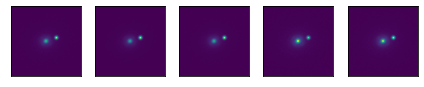

NITE:  -5
     g         r         i         z         Y


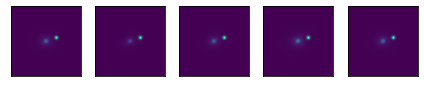

NITE:  0
     g         r         i         z         Y


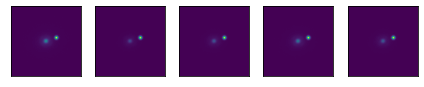

NITE:  5
     g         r         i         z         Y


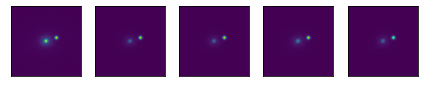

NITE:  10
     g         r         i         z         Y


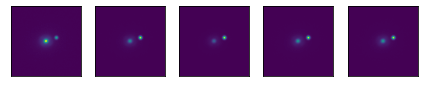

In [12]:
for idx in obj_indices:
    print("NITE: ", dataset.CONFIGURATION_3_metadata['PLANE_2-OBJECT_2-nite-g'].values[idx])
    print("     g         r         i         z         Y")
    view_image(dataset.CONFIGURATION_3_images[idx])

We can also access and plot the light curve of the point source like this:

In [13]:
import matplotlib.pyplot as plt

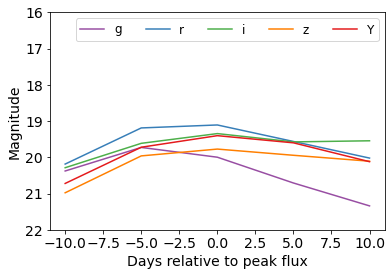

In [14]:
plt.figure()

color_dict = {'g': '#984ea3', 'r': '#377eb8', 'i': '#4daf4a', 'z': '#ff7f00', 'Y': '#e41a1c'}

for band in ['g', 'r', 'i', 'z', 'Y']:
    times = dataset.CONFIGURATION_3_metadata['PLANE_2-OBJECT_2-nite-{0}'.format(band)].values[obj_indices]
    mags = dataset.CONFIGURATION_3_metadata['PLANE_2-OBJECT_2-magnitude-{0}'.format(band)].values[obj_indices]
    
    plt.plot(times, mags, color=color_dict[band], label=band)
    
plt.legend(fontsize=12, ncol=5)
plt.ylim(22, 16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Days relative to peak flux", fontsize=14)
plt.ylabel("Magnitude", fontsize=14)
plt.show()